In [72]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sbn
from scipy import stats

In [30]:
# Importing the cleaned/combined data from the csv

firefile = './output/all_cleaned_formatted_fire_data.csv'
df = pd.read_csv(firefile, skip_blank_lines=True, encoding='UTF-8')
len(df)


126699

In [31]:
# Making a year column for merging Population data
df['Year'] = pd.DatetimeIndex(df['dispatch_date_time']).year


In [32]:
# Making a date column for merging the weather data later
df['Date'] = df['dispatch_date_time'].str.split(' ',expand=True)[0]

In [36]:
# Reformatting the datetimei columns from object to datetime

df['dispatch_date_time'] = pd.to_datetime(df['dispatch_date_time'])
df['cleared_date_time'] = pd.to_datetime(df['cleared_date_time'])
df['arrive_date_time'] = pd.to_datetime(df['arrive_date_time'])
df.dtypes

OBJECTID                               int64
address                               object
address2                              object
apt_room                              object
arrive_date_time              datetime64[ns]
cleared_date_time             datetime64[ns]
dispatch_date_time            datetime64[ns]
exposure                               int64
incident_number                       object
incident_type                          int64
incident_type_description             object
platoon                               object
station                                int64
Longitude                            float64
Latitude                             float64
Year                                   int64
Date                                  object
Clear Time                   timedelta64[ns]
Seconds                              float64
dtype: object

In [37]:
# Calculating the time from dispatch to cleared in minutes and in seconds
df['Clear Time'] = (df['cleared_date_time'] - df['dispatch_date_time'])
df['Clear Time'] = pd.to_timedelta(df['Clear Time'])
df['Seconds'] = df['Clear Time'].dt.total_seconds()


In [38]:
df.head()

,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Clear Time,Seconds
0,594766,"311 STONEY MOSS DR RALEIGH, NC 27601",,110,2015-08-01 02:51:00,2015-08-01 03:19:00,2015-08-01 02:47:00,0,15-0023269,743,Smoke detector activation no fire - unintentional,B,12,-78.581286,35.776604,2015,2015-08-01,00:32:00,1920.0
1,594767,"510 W JOHNSON ST RALEIGH, NC 27601",,,2015-07-08 18:57:00,2015-07-08 19:00:00,2015-07-08 18:53:00,0,15-0020778,743,Smoke detector activation no fire - unintentional,A,1,-78.646460,35.787319,2015,2015-07-08,00:07:00,420.0
2,594768,"2901 TRAWICK RD RALEIGH, NC 27601",UNITED SKATES OF AMERICA,,2015-07-10 12:44:00,2015-07-10 12:49:00,2015-07-10 12:41:00,0,15-0020961,735,Alarm system sounded due to malfunction,A,11,-78.589379,35.819701,2015,2015-07-10,00:08:00,480.0
3,594769,"3616 POOLE RD RALEIGH, NC 27601",BP GAS RA,,2015-07-18 17:22:00,2015-07-18 17:49:00,2015-07-18 17:19:00,0,15-0021810,671,HazMat release investigation w/no HazMat,C,12,-78.576563,35.767842,2015,2015-07-18,00:30:00,1800.0
4,594770,"101 DURHAM CO WAY RALEIGH, NC 27601",DCDH,,2015-07-08 21:30:00,2015-07-08 21:30:00,2015-07-08 21:21:00,0,15-9018104,611,Dispatched & cancelled en route,A,24,-78.634516,35.775469,2015,2015-07-08,00:09:00,540.0


In [ ]:
# There appear to be some funky clearance times, possibly human error
outlier = df.loc[df['Clear Time']==df['Clear Time'].max()]
no_outliers = df[df['Clear Time'] <= df['Clear Time'].mean() + 3 * df['Clear Time'].std()]
len(no_outliers)

In [113]:
years = no_outliers.groupby(['Year']).OBJECTID.count()
years

Year
2007    11718
2008    11810
2009    10840
2010    11093
2011    11220
2012    10906
2013    10983
2014    11448
2015    11948
2016    12402
2017    10410
2018      932
Name: OBJECTID, dtype: int64

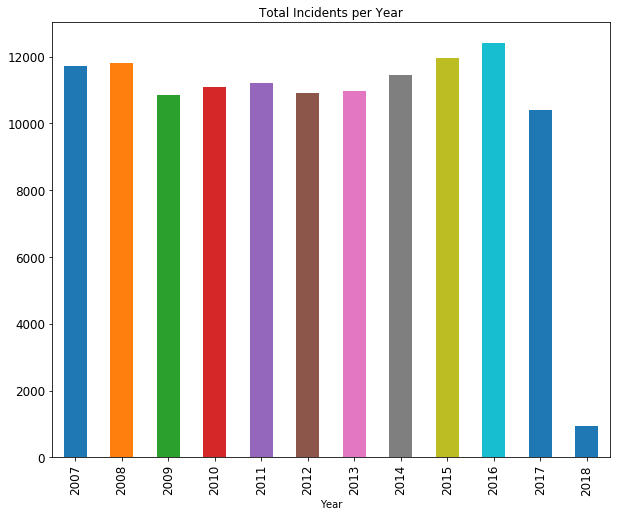

In [117]:
years.plot(kind='bar', figsize=(10,8), use_index=True, title='Total Incidents per Year', grid=False,fontsize=12)
plt.savefig('./graphics/total_fi_year.png')

In [187]:
### Trying to get at what stations were in the dataset per year
sl = no_outliers.groupby('station')['Year'].unique()
# sl.sort()
sl
# It looks like station 0 is a mistake, stage 13 only has records from 2008 and not listed on Wake Co FD list
# Station 29 came online in 2015

station
0                                                [2007]
1     [2015, 2012, 2011, 2007, 2014, 2013, 2010, 200...
2     [2015, 2008, 2010, 2012, 2013, 2007, 2009, 201...
3     [2015, 2008, 2007, 2013, 2012, 2010, 2014, 200...
4     [2015, 2014, 2012, 2010, 2013, 2008, 2011, 200...
5     [2015, 2013, 2010, 2011, 2007, 2014, 2009, 201...
6     [2015, 2008, 2009, 2013, 2007, 2011, 2012, 201...
7     [2015, 2011, 2014, 2009, 2013, 2012, 2008, 200...
8     [2015, 2007, 2014, 2011, 2013, 2008, 2010, 200...
9     [2015, 2014, 2010, 2011, 2007, 2012, 2008, 201...
10    [2015, 2011, 2007, 2009, 2008, 2012, 2010, 201...
11    [2015, 2010, 2011, 2009, 2012, 2008, 2007, 201...
12    [2015, 2007, 2011, 2009, 2012, 2008, 2010, 201...
13                                               [2008]
14    [2015, 2010, 2014, 2009, 2013, 2011, 2012, 200...
15    [2015, 2007, 2013, 2009, 2012, 2008, 2014, 201...
16    [2015, 2007, 2014, 2008, 2012, 2009, 2010, 201...
17    [2015, 2008, 2014, 2013, 2009, 200

In [189]:
# Create bins to group stations
bins = [0,7,14,21,30]
labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
# pd.cut(no_outliers["station"], bins, labels=labels).head()
no_outliers["Station Group"] = pd.cut(no_outliers["station"], bins, labels=labels)
no_outliers.head()

/Users/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,OBJECTID,address,address2,apt_room,arrive_date_time,cleared_date_time,dispatch_date_time,exposure,incident_number,incident_type,incident_type_description,platoon,station,Longitude,Latitude,Year,Date,Clear Time,Seconds,Station Group
0,594766,"311 STONEY MOSS DR RALEIGH, NC 27601",,110,2015-08-01 02:51:00,2015-08-01 03:19:00,2015-08-01 02:47:00,0,15-0023269,743,Smoke detector activation no fire - unintentional,B,12,-78.581286,35.776604,2015,2015-08-01,00:32:00,1920.0,Group 2
1,594767,"510 W JOHNSON ST RALEIGH, NC 27601",,,2015-07-08 18:57:00,2015-07-08 19:00:00,2015-07-08 18:53:00,0,15-0020778,743,Smoke detector activation no fire - unintentional,A,1,-78.646460,35.787319,2015,2015-07-08,00:07:00,420.0,Group 1
2,594768,"2901 TRAWICK RD RALEIGH, NC 27601",UNITED SKATES OF AMERICA,,2015-07-10 12:44:00,2015-07-10 12:49:00,2015-07-10 12:41:00,0,15-0020961,735,Alarm system sounded due to malfunction,A,11,-78.589379,35.819701,2015,2015-07-10,00:08:00,480.0,Group 2
3,594769,"3616 POOLE RD RALEIGH, NC 27601",BP GAS RA,,2015-07-18 17:22:00,2015-07-18 17:49:00,2015-07-18 17:19:00,0,15-0021810,671,HazMat release investigation w/no HazMat,C,12,-78.576563,35.767842,2015,2015-07-18,00:30:00,1800.0,Group 2
4,594770,"101 DURHAM CO WAY RALEIGH, NC 27601",DCDH,,2015-07-08 21:30:00,2015-07-08 21:30:00,2015-07-08 21:21:00,0,15-9018104,611,Dispatched & cancelled en route,A,24,-78.634516,35.775469,2015,2015-07-08,00:09:00,540.0,Group 4


In [190]:
station_groups = no_outliers.groupby(['Station Group','Year'])
station_groups['OBJECTID'].count()

Station Group  Year
Group 1        2007    3653
               2008    3647
               2009    3360
               2010    3144
               2011    3398
               2012    3652
               2013    3513
               2014    3548
               2015    3686
               2016    3610
               2017    3004
               2018     315
Group 2        2007    3241
               2008    3266
               2009    3028
               2010    3159
               2011    3172
               2012    2814
               2013    2965
               2014    3028
               2015    2983
               2016    3137
               2017    2616
               2018     285
Group 3        2007    2981
               2008    3037
               2009    2804
               2010    2878
               2011    2808
               2012    2681
               2013    2736
               2014    2999
               2015    3175
               2016    3492
               2017    3073


In [175]:
len(station_groups)

49